# BNK48 Social Media Data Exploration
Dataset from www.bnk48scouter.com which records likes/followers amount of each BNK48 member hourly for both Facebook and Instagram.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fb_file = 'datasets/fb_2018-11-03.csv'
ig_file = 'datasets/ig_2018-11-03.csv'

fb = pd.read_csv(fb_file, names = ['name','datetime','fans'], header=0, parse_dates=['datetime'])
ig = pd.read_csv(ig_file, names = ['name','datetime','fans'], header=0, parse_dates=['datetime'])

member_info = pd.read_csv('datasets/bnk48member_info.csv')
member_info = member_info.query('active == 1')

fb_name_mapper = member_info.set_index('fb_name')['name']
ig_name_mapper = member_info.set_index('ig_name')['name']
gen_mapper = member_info.set_index('name')['generation']

# Map facebook names to their actual names and drop inactive members' info
fb = fb.assign(name = fb['name'].map(fb_name_mapper)).dropna()
# Map instagram names to their actual names and drop inactive members' info
ig = ig.assign(name = ig['name'].map(ig_name_mapper)).dropna()

In [3]:
# Adjusting timeframe
# 1. We need timestamps to be on an exact hour (some has YYYY-MM-DD 19:52:00) -> resample to Hour frequency
# 2. Absence of data of some members on some timestamps -> interpolate

# Pivot and inspect on missing values
pivot_fb = fb.pivot('datetime','name','fans')
pivot_ig = ig.pivot('datetime','name','fans')

pivot_fb = pivot_fb.resample('H').interpolate('time')
pivot_ig = pivot_ig.resample('H').interpolate('time')

# Check if there are still missing values
assert ~pivot_fb.isnull().any().any()
assert ~pivot_ig.isnull().any().any()
# Check if there are still timestamps which are not on exact hour
assert pivot_fb.index.minute.unique() == [0]
assert pivot_ig.index.minute.unique() == [0]

pivot_fb.shape, pivot_ig.shape

((768, 52), (768, 52))

In [4]:
# Store start and end of the period
from_dt, to_dt = pivot_fb.index.min(), pivot_fb.index.max()

# Format start and end dates
from_text, to_text = from_dt.strftime('%b %d, %Y'), to_dt.strftime('%b %d, %Y')

print('Period: {} - {}'.format(from_dt, to_dt))

Period: 2018-10-02 19:00:00 - 2018-11-03 18:00:00


In [5]:
# Update back 
fb = pivot_fb.reset_index().melt(id_vars='datetime', value_name='fans')
ig = pivot_ig.reset_index().melt(id_vars='datetime', value_name='fans')

# Compute amounts of likes, followers diff for each hour 
# Then shift the diff values to the begining of the period
# Ex. 6:00:00 = 2, 7:00:00 = 3 -> by default, diff() will give 6:00:00 = NaN, 7:00:00 = 1
# Shift by -1 will yeild the result of 6:00:00 = 1 to represent the amount of likes gained during 6-7 o'clock
# This is to prevent the likes during 23:00 - 0:00 falls at 0:00 on the next date, 
# it will instead fall to 23:00 of the current date
fb_change = pivot_fb.diff().shift(-1).dropna()
ig_change = pivot_ig.diff().shift(-1).dropna()

### Facebook ranking
Who has the highest like on Facebook?

In [6]:
fb_stat = fb.groupby('name')['fans'].agg(['first','last'])
fb_stat.columns = ['prev_fans', 'fans']

fb_stat['growth'] = fb_stat['fans'] - fb_stat['prev_fans']
fb_stat['pct_growth'] = fb_stat['growth']/fb_stat['prev_fans']
fb_stat = fb_stat.join(gen_mapper)

fb_stat.sort_values('fans', ascending=False).head(16)

,prev_fans,fans,growth,pct_growth,generation
name,,,,,
Cherprang,550544.0,617480.0,66936.0,0.121582,1
Pun,548487.0,587107.0,38620.0,0.070412,1
Orn,347979.0,378229.0,30250.0,0.086931,1
Jennis,275686.0,304151.0,28465.0,0.103252,1
Noey,274719.0,301978.0,27259.0,0.099225,1
Mobile,271822.0,296462.0,24640.0,0.090648,1
Music,264967.0,295674.0,30707.0,0.115890,1
Kaimook,248690.0,269688.0,20998.0,0.084434,1
Kaew,217473.0,240977.0,23504.0,0.108078,1


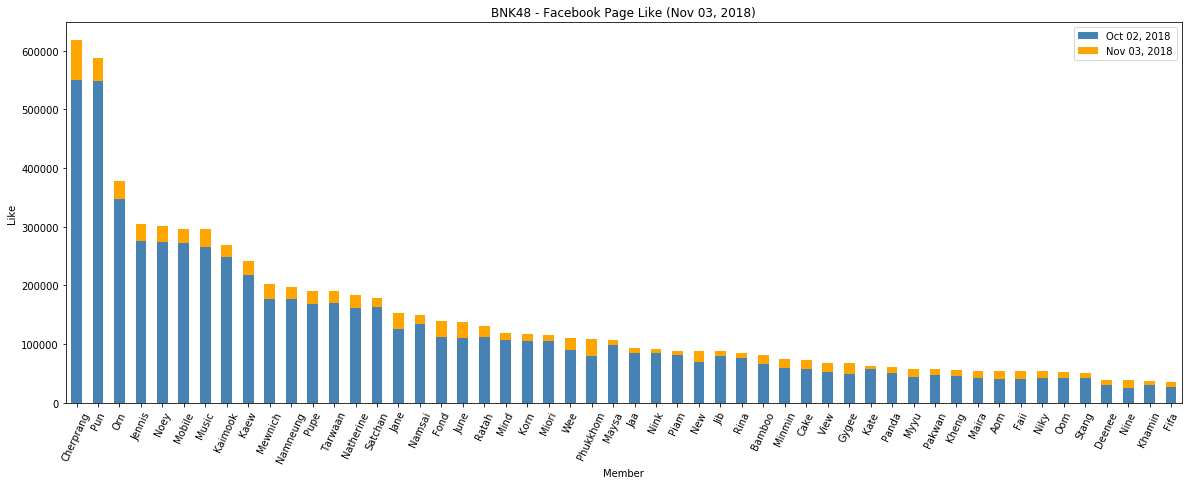

In [7]:
fb_stat.sort_values('fans', ascending=False)[['prev_fans','growth']].plot.bar(
                stacked=True, rot=65, figsize=(20,7), color=['steelblue','orange'])
plt.title('BNK48 - Facebook Page Like ({})'.format(to_text))
plt.xlabel('Member')
plt.ylabel('Like')
plt.legend(labels=[from_text, to_text]);

### Facebook top-gainer ranking
Who gains the highest likes on Facebook for the period?

In [8]:
fb_stat.sort_values('growth',ascending=False).head(16)

,prev_fans,fans,growth,pct_growth,generation
name,,,,,
Cherprang,550544.0,617480.0,66936.0,0.121582,1
Pun,548487.0,587107.0,38620.0,0.070412,1
Music,264967.0,295674.0,30707.0,0.115890,1
Phukkhom,79214.0,109620.0,30406.0,0.383846,2
Orn,347979.0,378229.0,30250.0,0.086931,1
Jennis,275686.0,304151.0,28465.0,0.103252,1
Jane,125332.0,152802.0,27470.0,0.219178,1
Noey,274719.0,301978.0,27259.0,0.099225,1
June,111289.0,138137.0,26848.0,0.241246,2


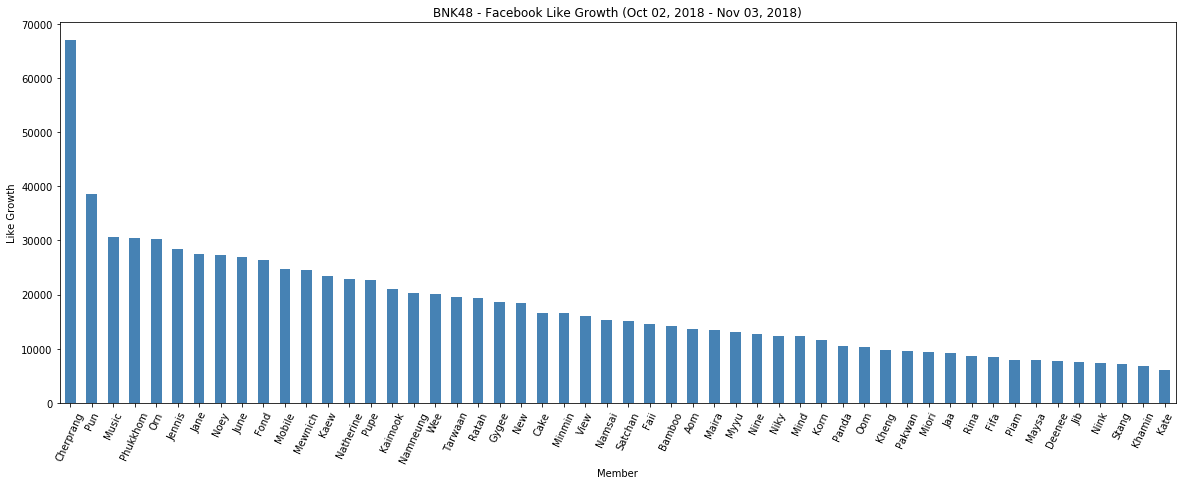

In [9]:
fb_stat.sort_values('growth',ascending=False)['growth'].plot.bar(figsize=(20,7), rot=65, color='steelblue')
plt.title('BNK48 - Facebook Like Growth ({} - {})'.format(from_text, to_text))
plt.xlabel('Member')
plt.ylabel('Like Growth');

### Instagram ranking
Who has the highest follower on Facebook?

In [10]:
ig_stat = ig.groupby('name')['fans'].agg(['first','last'])
ig_stat.columns = ['prev_fans', 'fans']

ig_stat['growth'] = ig_stat['fans'] - ig_stat['prev_fans']
ig_stat['pct_growth'] = ig_stat['growth']/ig_stat['prev_fans']
ig_stat = ig_stat.join(gen_mapper)

ig_stat.sort_values('fans', ascending=False).head(10)

,prev_fans,fans,growth,pct_growth,generation
name,,,,,
Pun,716066.0,807369.0,91303.0,0.127506,1
Cherprang,560974.0,670985.0,110011.0,0.196107,1
Orn,510745.0,581036.0,70291.0,0.137624,1
Jennis,457814.0,524608.0,66794.0,0.145898,1
Mobile,452668.0,521955.0,69287.0,0.153064,1
Music,435485.0,494340.0,58855.0,0.135148,1
Noey,403389.0,469243.0,65854.0,0.163252,1
Kaimook,378725.0,438363.0,59638.0,0.157470,1
Jane,325306.0,406403.0,81097.0,0.249295,1


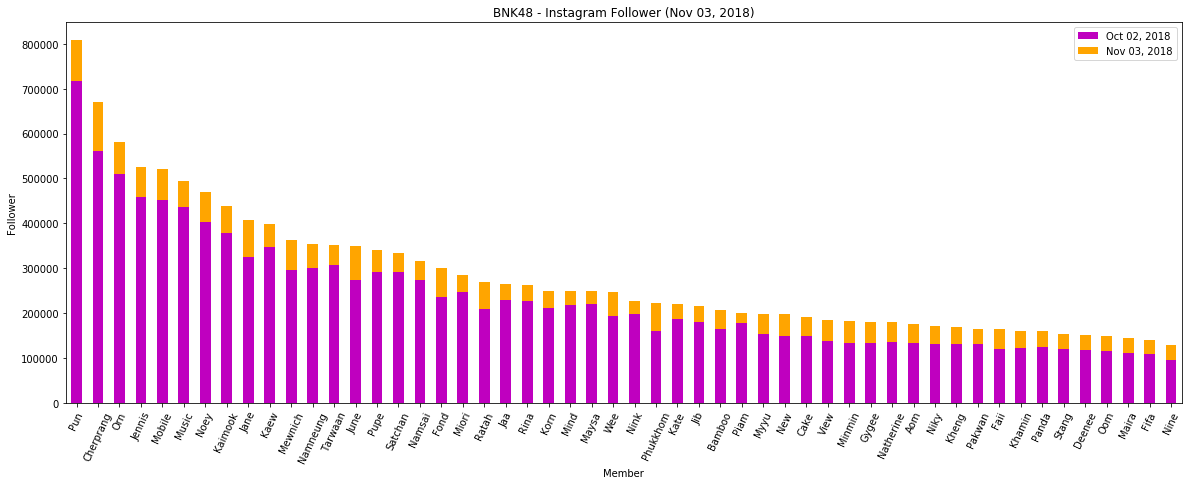

In [11]:
ig_stat.sort_values('fans', ascending=False)[['prev_fans','growth']].plot.bar(
                stacked=True, rot=65, figsize=(20,7), color=['m','orange'])
plt.title('BNK48 - Instagram Follower ({})'.format(to_text))
plt.xlabel('Member')
plt.ylabel('Follower')
plt.legend(labels=[from_text, to_text]);

### Instagram top-gainer ranking
Who gains the highest followers on Instagram for the period?

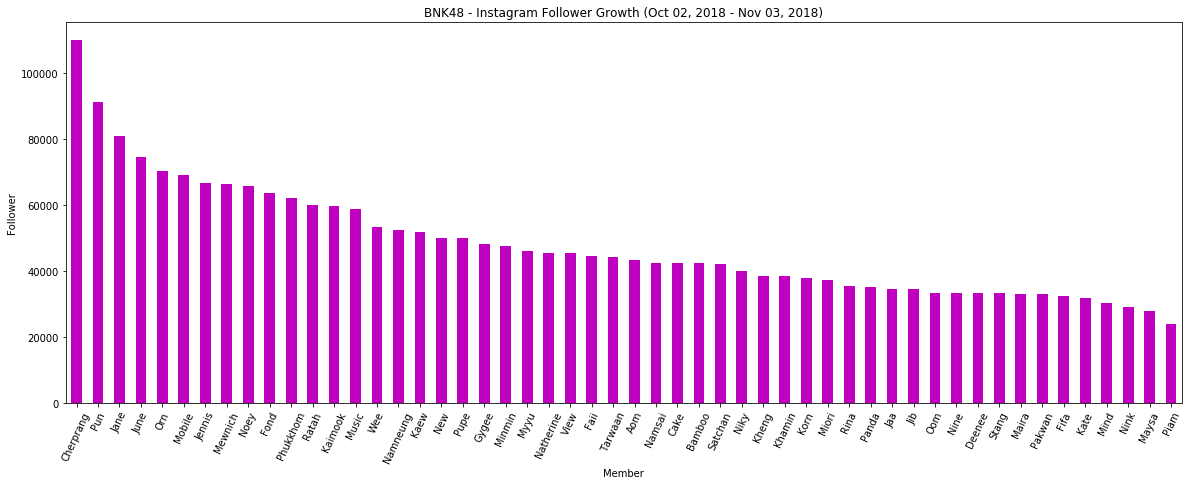

In [12]:
ig_stat.sort_values('growth',ascending=False)['growth'].plot.bar(figsize=(20,7), rot=65, color='m')
plt.title('BNK48 - Instagram Follower Growth ({} - {})'.format(from_text, to_text))
plt.xlabel('Member')
plt.ylabel('Follower');

### Facebook Timeseries

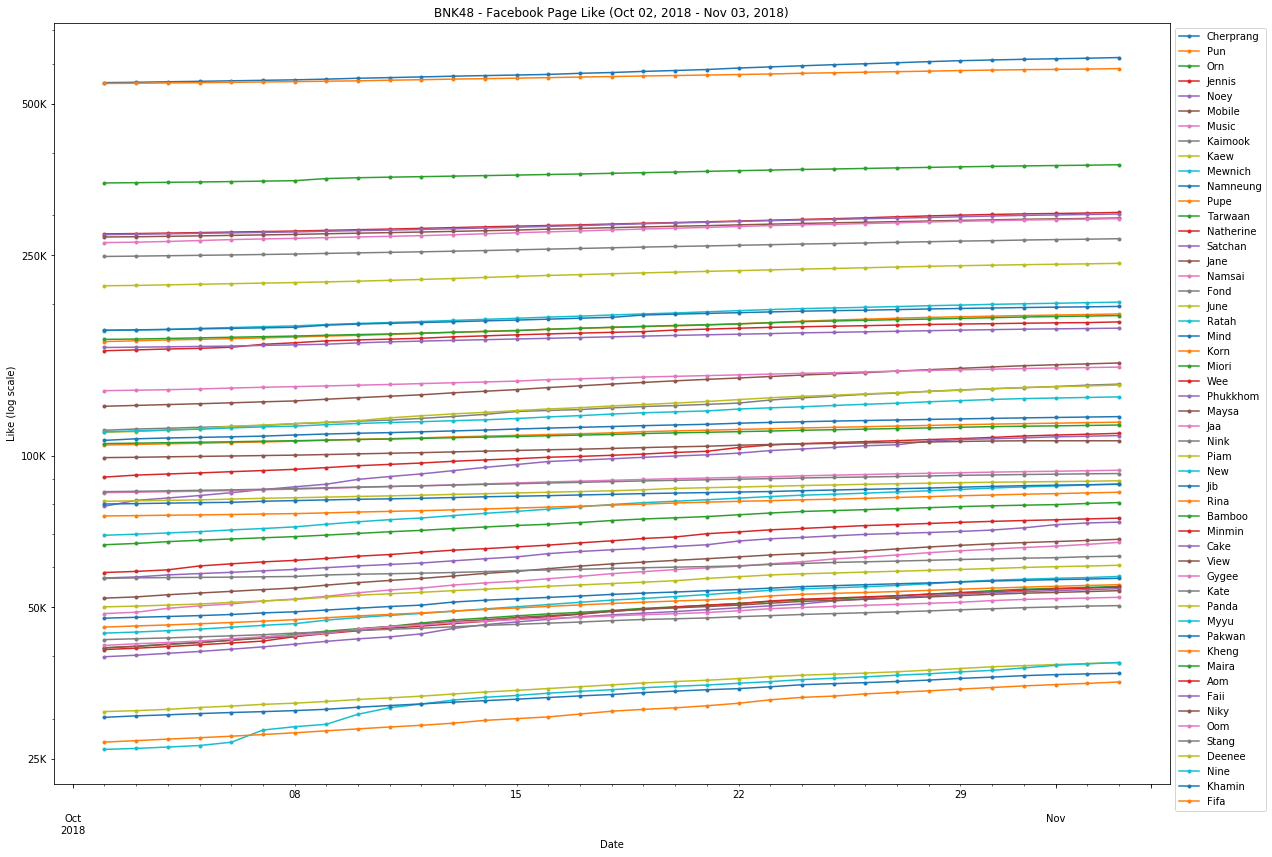

In [13]:
# List of names ordered by fans descendingly
fb_ranked_names = fb_stat.sort_values('fans', ascending=False).index.values

data = pivot_fb.resample('D').last()[fb_ranked_names]
data.plot(figsize=(20,14), logy=True, title='BNK48 - Facebook Page Like ({} - {})'.format(from_text, to_text), marker='.')

plt.xlabel('Date')
plt.ylabel('Like (log scale)')
plt.yticks([2.5e4, 5e4,1e5,2.5e5,5e5],['25K','50K','100K','250K','500K']);
plt.legend(bbox_to_anchor=(1,1));

### Line plot focused on top-gainers

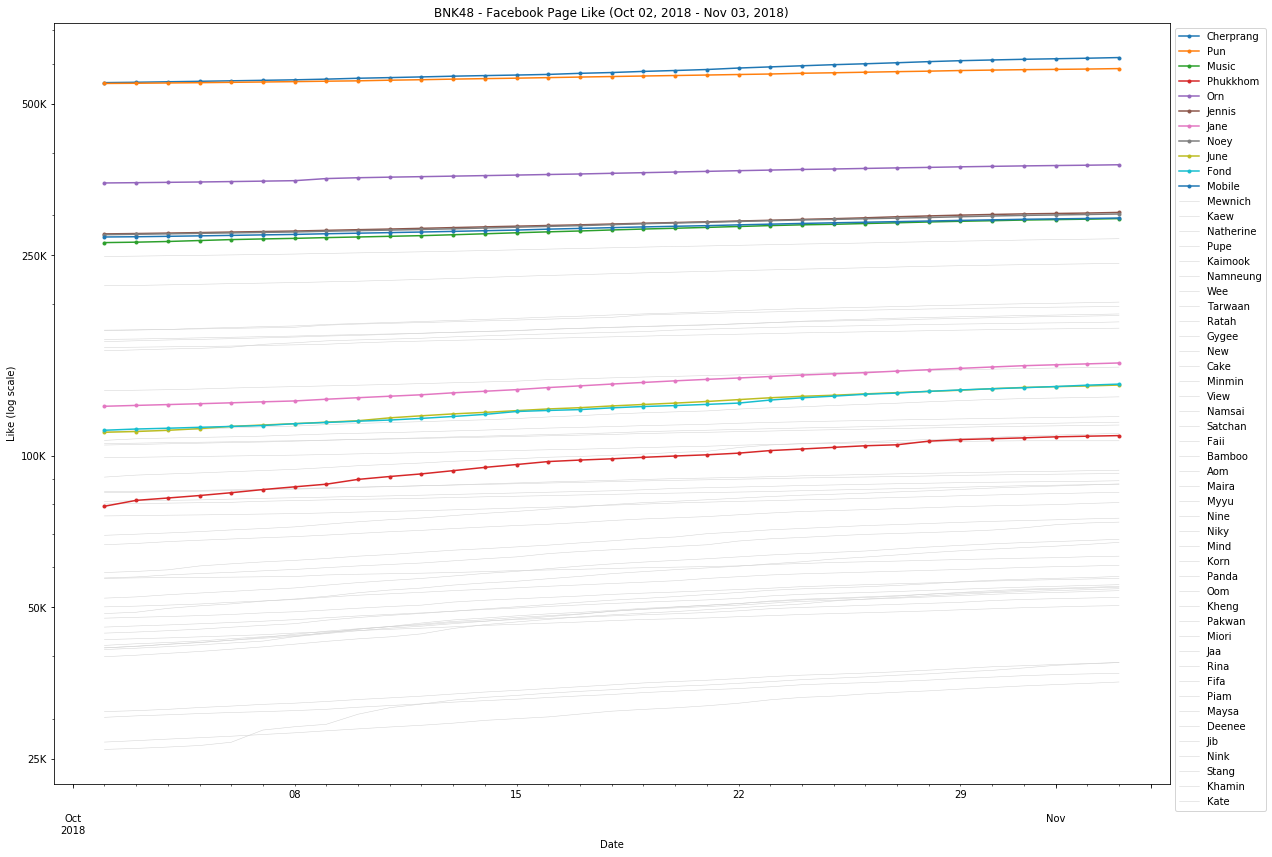

In [14]:
names = fb_stat.sort_values('growth',ascending=False).index
n = 11

ax = data[names[n:]].plot(figsize=(20,14), logy=True, color='lightgrey', linewidth=.50)
data[names[:n]].plot(ax=ax, marker='.')

plt.title('BNK48 - Facebook Page Like ({} - {})'.format(from_text, to_text))
plt.xlabel('Date')
plt.ylabel('Like (log scale)')
plt.yticks([2.5e4, 5e4,1e5,2.5e5,5e5],['25K','50K','100K','250K','500K']);

# Adjust legend
handles, labels = ax.get_legend_handles_labels()
handles = handles[-n:] + handles[:-n]
labels = labels[-n:] + labels[:-n]
ax.legend(handles, labels, bbox_to_anchor=(1,1));

### Instagram Timeseries

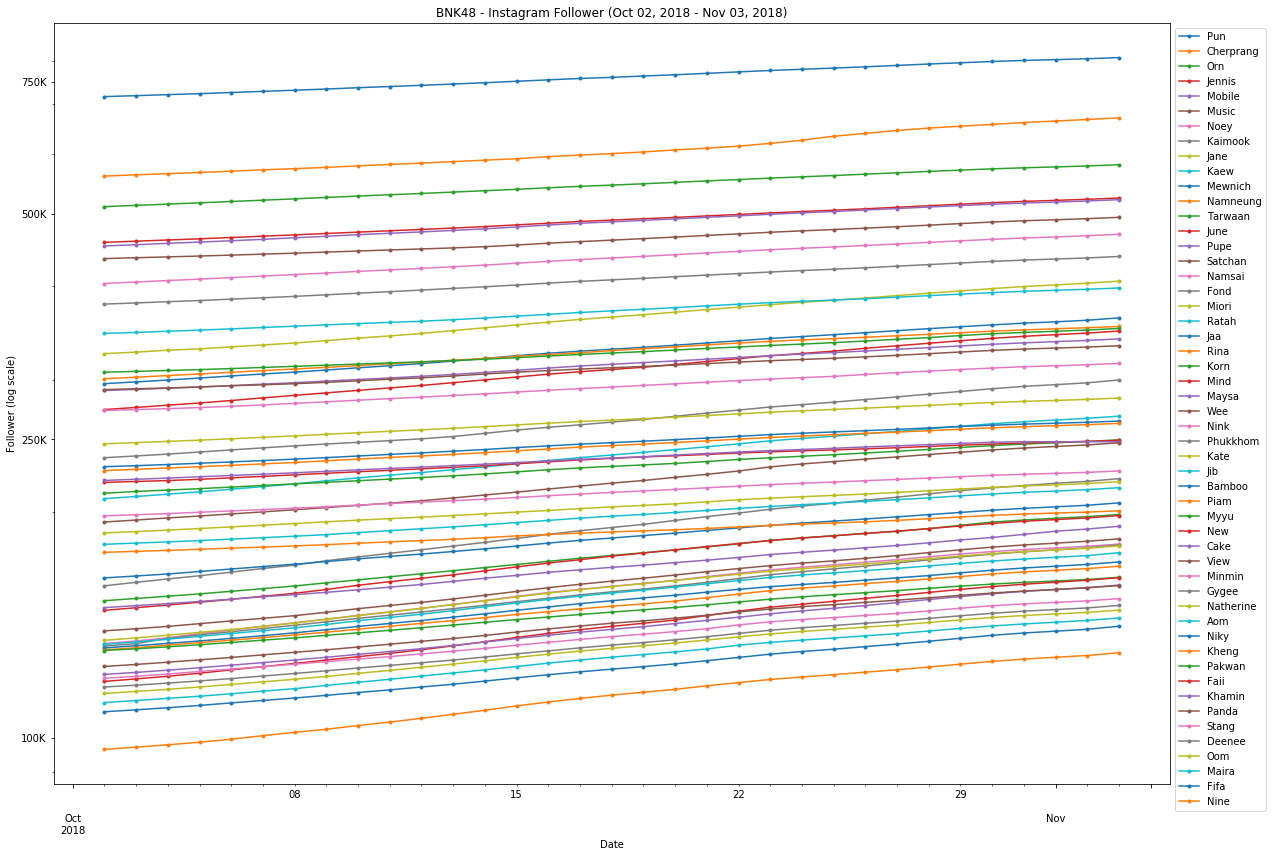

In [15]:
# List of names ordered by fans descendingly
ig_ranked_names = ig_stat.sort_values('fans', ascending=False).index.values

data = pivot_ig.resample('D').last()[ig_ranked_names]
data.plot(figsize=(20,14), logy=True, title='BNK48 - Instagram Follower ({} - {})'.format(from_text, to_text), marker='.')

plt.xlabel('Date')
plt.ylabel('Follower (log scale)')
plt.yticks([1e5,2.5e5, 5e5,7.5e5],['100K','250K','500K','750K']);
plt.legend(bbox_to_anchor=(1,1));

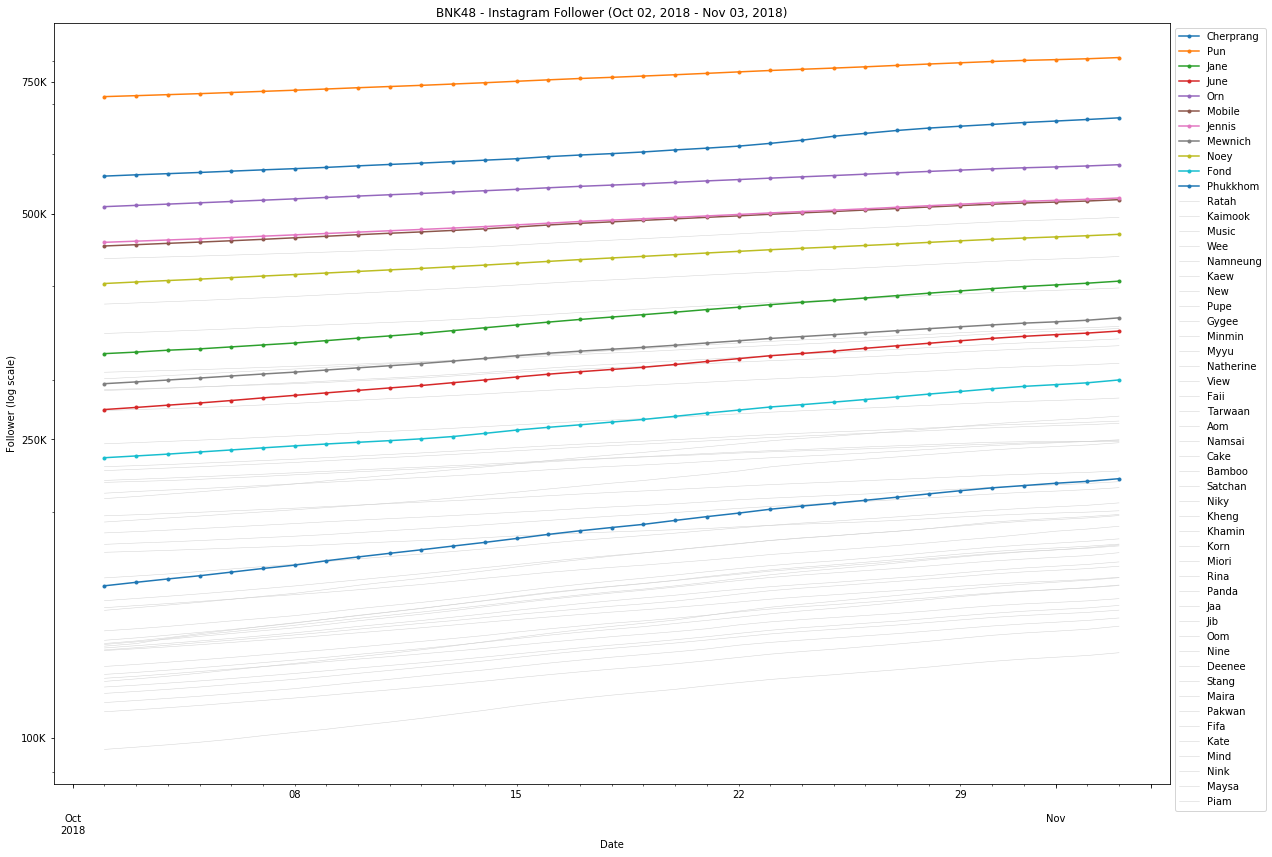

In [16]:
names = ig_stat.sort_values('growth',ascending=False).index
n = 11

ax = data[names[n:]].plot(figsize=(20,14), logy=True, color='lightgrey', linewidth=.5)
data[names[:n]].plot(ax=ax, marker='.')

plt.title('BNK48 - Instagram Follower ({} - {})'.format(from_text, to_text))
plt.xlabel('Date')
plt.ylabel('Follower (log scale)')
plt.yticks([1e5,2.5e5, 5e5,7.5e5],['100K','250K','500K','750K']);

# Adjust legend
handles, labels = ax.get_legend_handles_labels()
handles = handles[-n:] + handles[:-n]
labels = labels[-n:] + labels[:-n]
ax.legend(handles, labels, bbox_to_anchor=(1,1));

### Growth by hour
Observation:
- For both FB and IG, we can see a repetitive pattern for each day. We'll plot heatmaps to see this pattern further.
- Spot some noises from IG graph with extremely high positive and negative gains. We'll skip plotting heatmaps for IG for now.

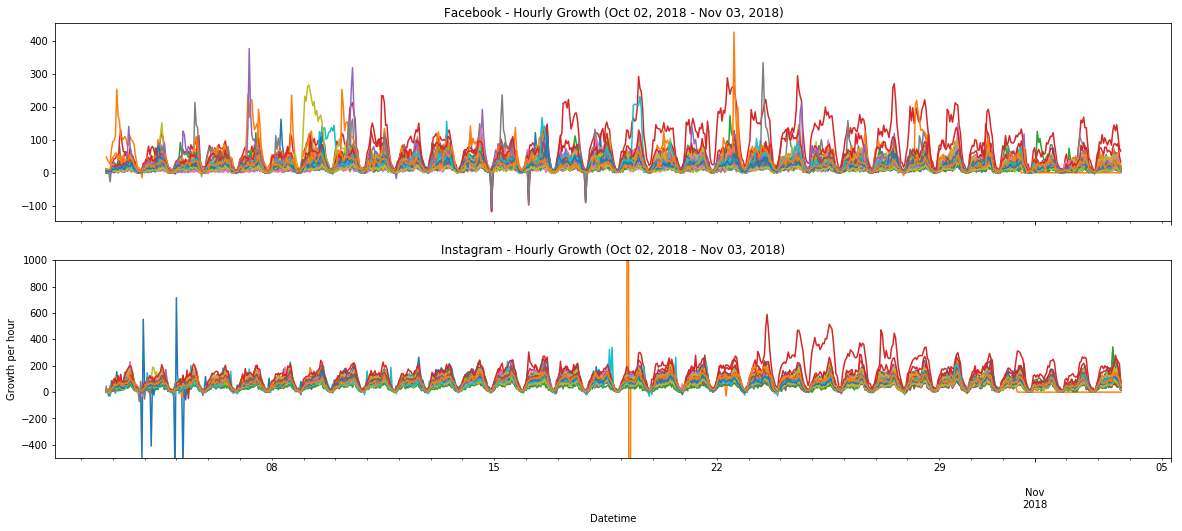

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,8))

fb_change.plot(title='Facebook - Hourly Growth ({} - {})'.format(from_text, to_text), legend=False, ax=ax1)
plt.xlabel('Datetime')
plt.ylabel('Growth per hour');

ig_change.plot(title='Instagram - Hourly Growth ({} - {})'.format(from_text, to_text), legend=False, ylim=(-500,1000), ax=ax2)
plt.xlabel('Datetime')
plt.ylabel('Growth per hour');

In [18]:
growth_df = fb_change.reset_index().melt('datetime', value_name='growth')
growth_df = growth_df.assign(weekday = growth_df['datetime'].dt.weekday_name, 
                             hour = growth_df['datetime'].dt.hour)
growth_df = growth_df.join(gen_mapper, on='name')
growth_df.head()

,datetime,name,growth,weekday,hour,generation
0,2018-10-02 19:00:00,Aom,3.0,Tuesday,19,2
1,2018-10-02 20:00:00,Aom,4.0,Tuesday,20,2
2,2018-10-02 21:00:00,Aom,6.0,Tuesday,21,2
3,2018-10-02 22:00:00,Aom,4.0,Tuesday,22,2
4,2018-10-02 23:00:00,Aom,5.0,Tuesday,23,2


### Growth Heatmap
Facebook average growth for each member by hour-of-day and day-of-week. 

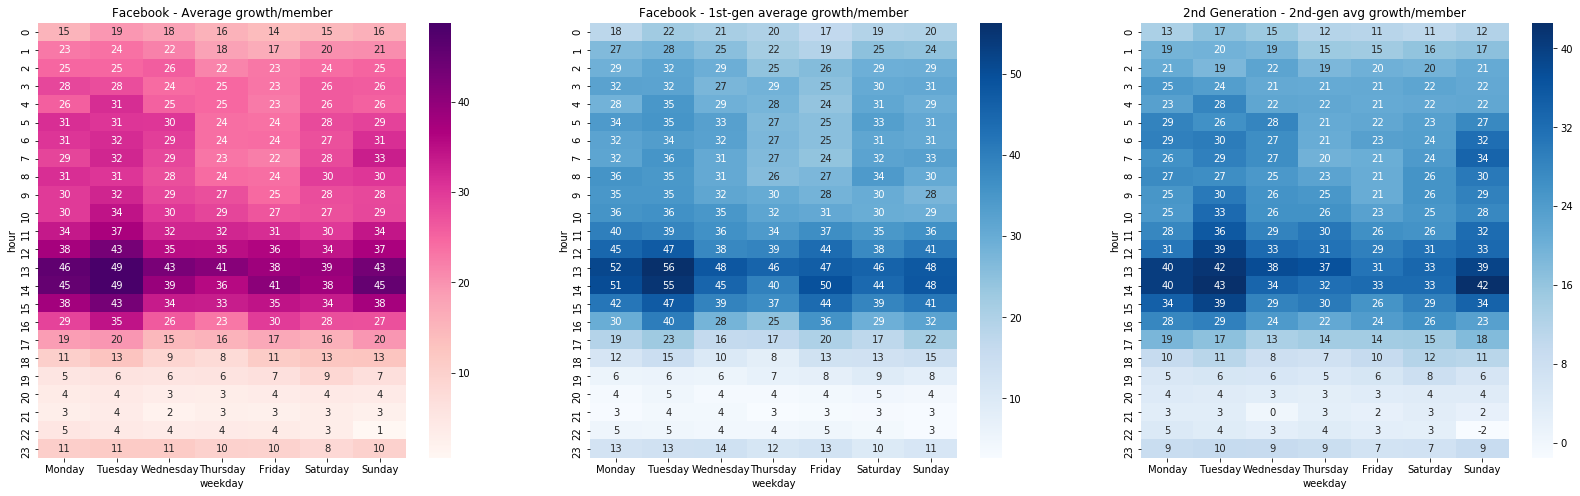

In [19]:
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

def transform_heatmap(data):
    data = data.groupby(['weekday', 'hour'], as_index=False).mean()
    data = data.pivot(index='hour', columns='weekday', values='growth')
    data = data.loc[:,weekdays]
    return data

# Heatmap for the whole band, 1st gen, 2nd gen
data = transform_heatmap(growth_df)
gen1_data = transform_heatmap(growth_df[growth_df['generation']==1])
gen2_data = transform_heatmap(growth_df[growth_df['generation']==2])

plt.figure(figsize=(28,8))
plt.subplot(131)
sns.heatmap(data, annot=True, fmt='.0f', cmap='RdPu')
plt.title('Facebook - Average growth/member')

plt.subplot(132)
sns.heatmap(gen1_data, annot=True, fmt='.0f', cmap='Blues')
plt.title('Facebook - 1st-gen average growth/member')

plt.subplot(133)
sns.heatmap(gen2_data, annot=True, fmt='.0f', cmap='Blues')
plt.title('2nd Generation - 2nd-gen avg growth/member');

- Basically the active growth period is during 1:00 - 16:00 for each day
- Most active growth period is during 11:00 - 15:00 for each day
- Least active growth period is during 18:00 - 23:00 for each day

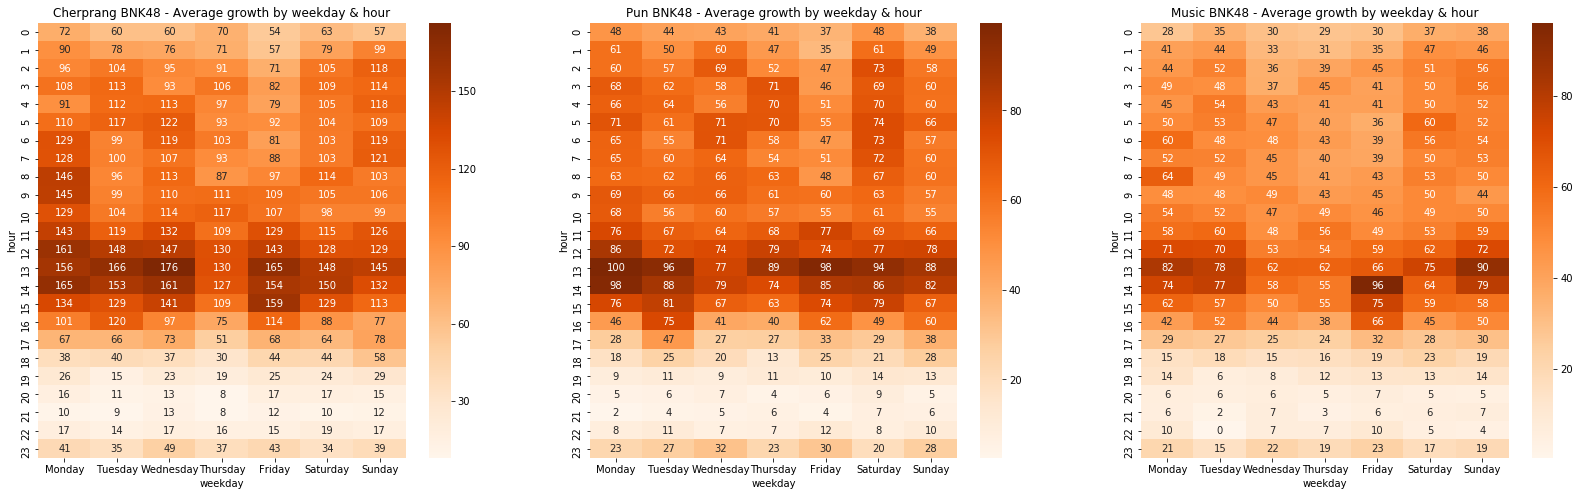

In [31]:
# Let's focus on these 3 top gainers
m = fb_stat.sort_values('growth',ascending=False).index[:3].values
heatmap1 = transform_heatmap(growth_df[growth_df['name']==m[0]])
heatmap2 = transform_heatmap(growth_df[growth_df['name']==m[1]])
heatmap3 = transform_heatmap(growth_df[growth_df['name']==m[2]])

colors='Oranges'

plt.figure(figsize=(28,8))

plt.subplot(131)
sns.heatmap(heatmap1, annot=True, fmt='.0f', cmap=colors)
plt.title('{} BNK48 - Average growth by weekday & hour'.format(m[0]))
                                       
plt.subplot(132)
sns.heatmap(heatmap2, annot=True, fmt='.0f', cmap=colors)
plt.title('{} BNK48 - Average growth by weekday & hour'.format(m[1]))

plt.subplot(133)
sns.heatmap(heatmap3, annot=True, fmt='.0f', cmap=colors)
plt.title('{} BNK48 - Average growth by weekday & hour'.format(m[2]));

## Hierarchical Clustering
Let's see, during this 30-day period, how their like/follower movements are grouped together.

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import normalize

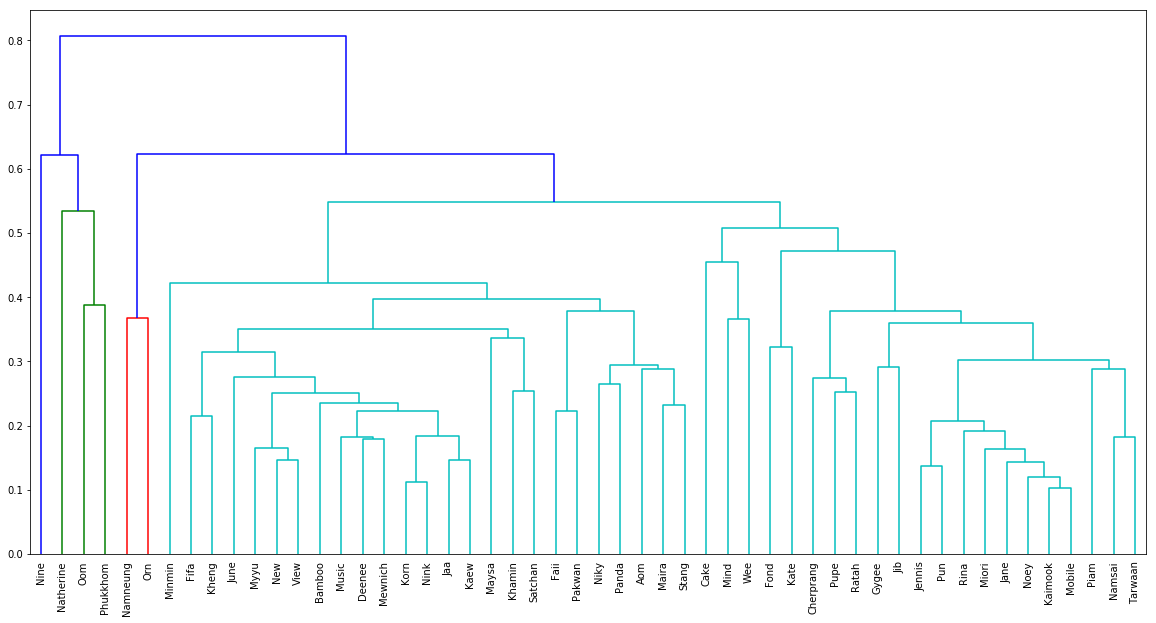

In [22]:
movements = fb_change.resample('D').sum().T

normalized_movements = normalize(movements)
names = movements.index.values

mergings = linkage(normalized_movements, method='complete')
plt.figure(figsize=(20,10))
dendrogram(mergings, labels=names, leaf_rotation=90, leaf_font_size=10);

#### Intermediate clustering at a designated distance

In [32]:
labels = fcluster(mergings, 0.6, criterion='distance')
groups = pd.DataFrame({'member':names, 'group': labels})
groups.groupby('group').count()

,member
group,
1,3
2,1
3,2
4,46


#### Visually inspecting each cluster

In [ ]:
max_cols = 5

for i in sorted(groups.group.unique()):
    m = groups[groups['group']==i]['member']

    if(m.count() <= max_cols):
        ncols = m.count()
        nrows = 1
    else:
        ncols = max_cols
        nrows = int(m.count()/max_cols) + (m.count()%max_cols != 0)
    pivot_fb[m].plot(subplots=True, layout=(nrows, ncols), figsize=(ncols*4,nrows*2), title='Group {}'.format(i))